tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Tokenized input with BOS and EOS tokens: ['<s>', 'How', 'are', 'you', '?', '</s>']
Hidden states shape: (33, 6, 4096)
Reduced shape: (33, 6, 2)


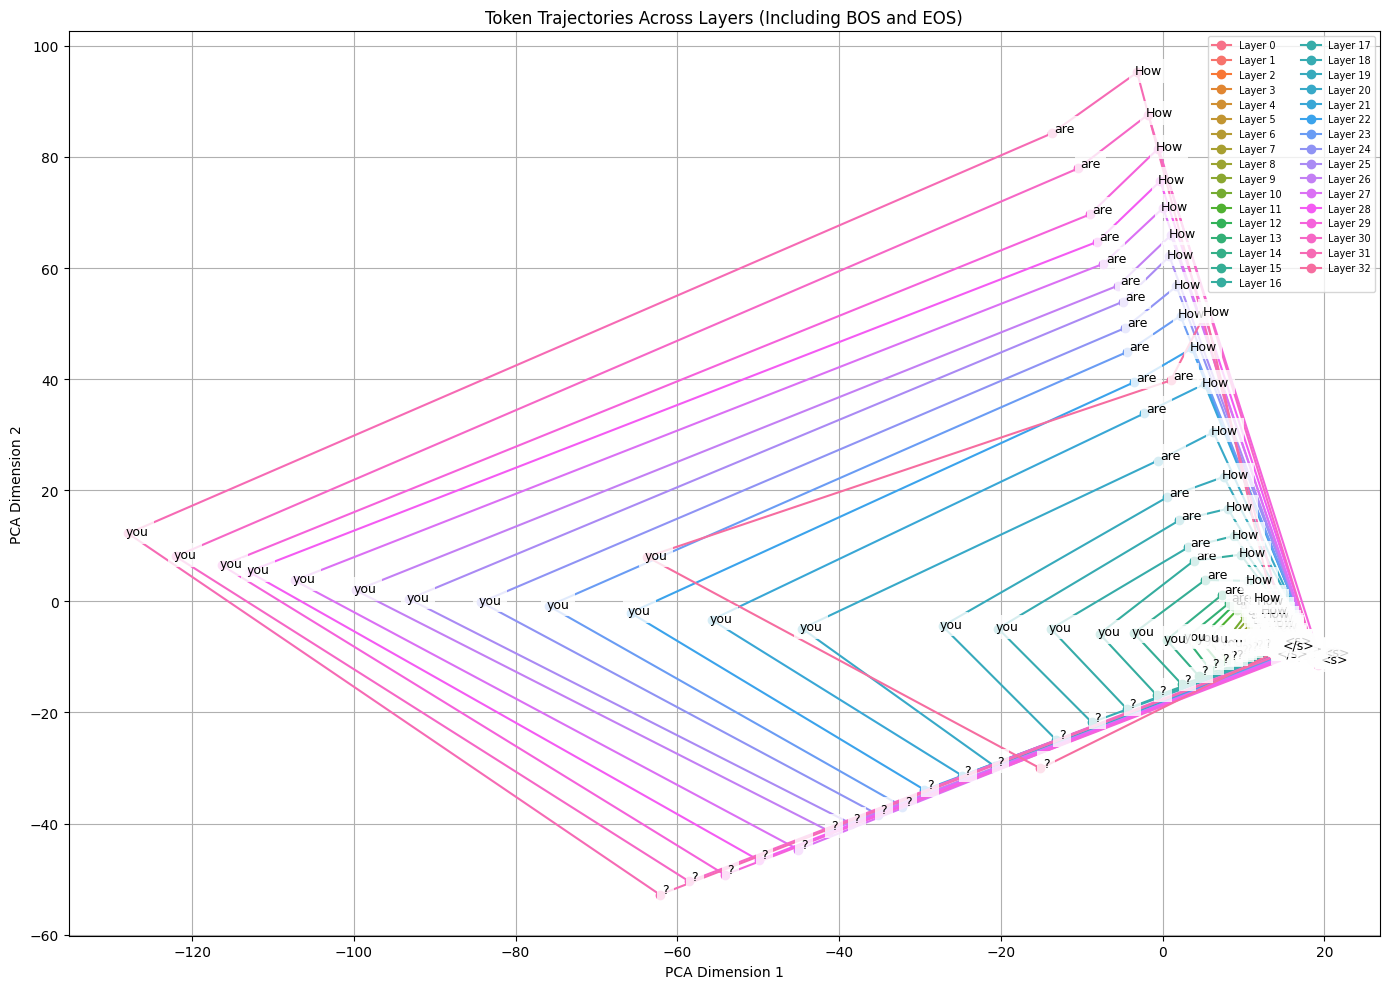

In [ ]:



# Import necessary libraries
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Model and Tokenizer Setup
model_name = "meta-llama/Llama-2-7b-hf"
hf_token = ""  # Actual Hugging Face token

# Load tokenizer and model with token
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(
    model_name, token=hf_token, device_map="auto",
    offload_folder="offload", torch_dtype=torch.float16
)  # Folder to store offloaded parameters, use FP16 to reduce memory usage

# Ensure model is in evaluation mode
model.eval()

# Step 2: Tokenize input with explicit BOS and EOS tokens
input_text = "How are you?"
# Explicitly add BOS and EOS tokens
inputs = tokenizer(
    input_text, return_tensors="pt", add_special_tokens=False
)  # Do not automatically add special tokens
input_ids = inputs["input_ids"].to("cuda" if torch.cuda.is_available() else "cpu")

# Get BOS and EOS token IDs
bos_token_id = tokenizer.bos_token_id  # <s>
eos_token_id = tokenizer.eos_token_id  # </s>


input_ids = torch.cat([
    torch.tensor([[bos_token_id]], device=input_ids.device),  # Add BOS
    input_ids,
    torch.tensor([[eos_token_id]], device=input_ids.device)   # Add EOS
], dim=1)

# Decode tokens for visualization, ensuring special tokens are preserved
token_strs = []
for token_id in input_ids[0]:
    decoded = tokenizer.decode([token_id], skip_special_tokens=False).strip()
    # Replace special token IDs with their string representations if needed
    if token_id.item() == bos_token_id:
        decoded = "<s>"
    elif token_id.item() == eos_token_id:
        decoded = "</s>"
    if decoded:  # Only include non-empty strings
        token_strs.append(decoded)
print(f"Tokenized input with BOS and EOS tokens: {token_strs}")

# Step 3: Model Inference and Hidden State Extraction
with torch.no_grad():
    outputs = model(input_ids, output_hidden_states=True)
    hidden_states = outputs.hidden_states  # List of (batch_size, seq_len, hidden_size) for each layer

# Convert hidden states to numpy for PCA
num_layers = len(hidden_states)  # 33 (embedding + 32 transformer layers)
num_tokens = input_ids.shape[1]
embed_dim = hidden_states[0].shape[-1]  # 4096 for LLaMA-2-7B
layer_matrix = np.stack([hs[0].cpu().numpy() for hs in hidden_states])  # Shape: (num_layers, num_tokens, embed_dim)
print(f"Hidden states shape: {layer_matrix.shape}")

# Step 4: Preprocessing and Normalization
reshaped = layer_matrix.reshape(-1, embed_dim)  # Shape: (num_layers * num_tokens, embed_dim)
scaler = StandardScaler()
reshaped_normalized = scaler.fit_transform(reshaped)

# Step 5: PCA Reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(reshaped_normalized)
reduced = reduced.reshape(num_layers, num_tokens, 2)  # Shape: (num_layers, num_tokens, 2)
print(f"Reduced shape: {reduced.shape}")

# Step 6: Visualization of Token Trajectories
layer_colors = sns.color_palette("husl", num_layers)
plt.figure(figsize=(14, 10))  # Increase figure size for clarity
for layer_idx in range(num_layers):
    coords = reduced[layer_idx]
    plt.plot(coords[:, 0], coords[:, 1], marker='o', color=layer_colors[layer_idx], label=f"Layer {layer_idx}")
    for tok_idx, token in enumerate(token_strs):
        # Adjust text position with slight offset to avoid overlap
        offset_x = 0.3 if tok_idx % 2 == 0 else -0.3  # Alternate offsets
        offset_y = 0.3 if tok_idx % 2 == 0 else -0.3
        plt.text(
            coords[tok_idx, 0] + offset_x,
            coords[tok_idx, 1] + offset_y,
            token,
            fontsize=9,  # Increase font size
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')  # Add background for readability
        )

plt.title("Token Trajectories Across Layers (Including BOS and EOS)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generated response: I hope you're
Response tokens: ['<s>', 'I', 'hope', 'you', "'", 're']


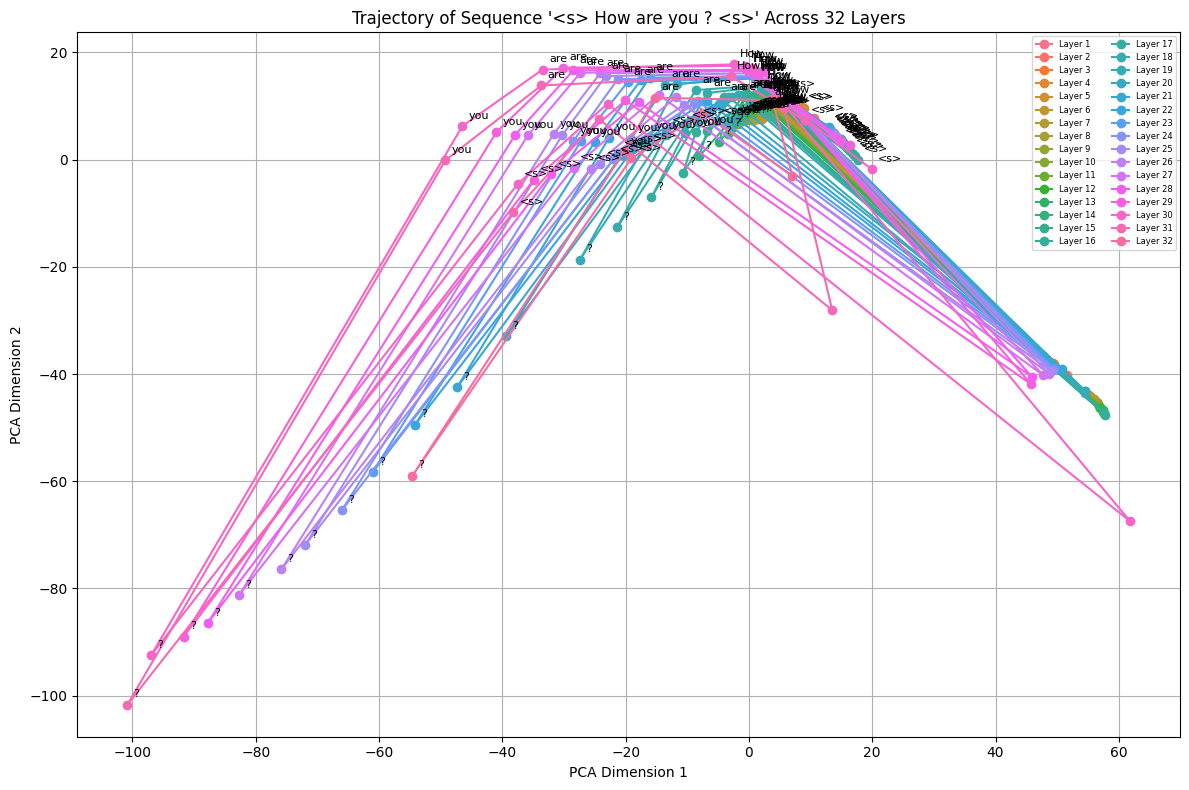

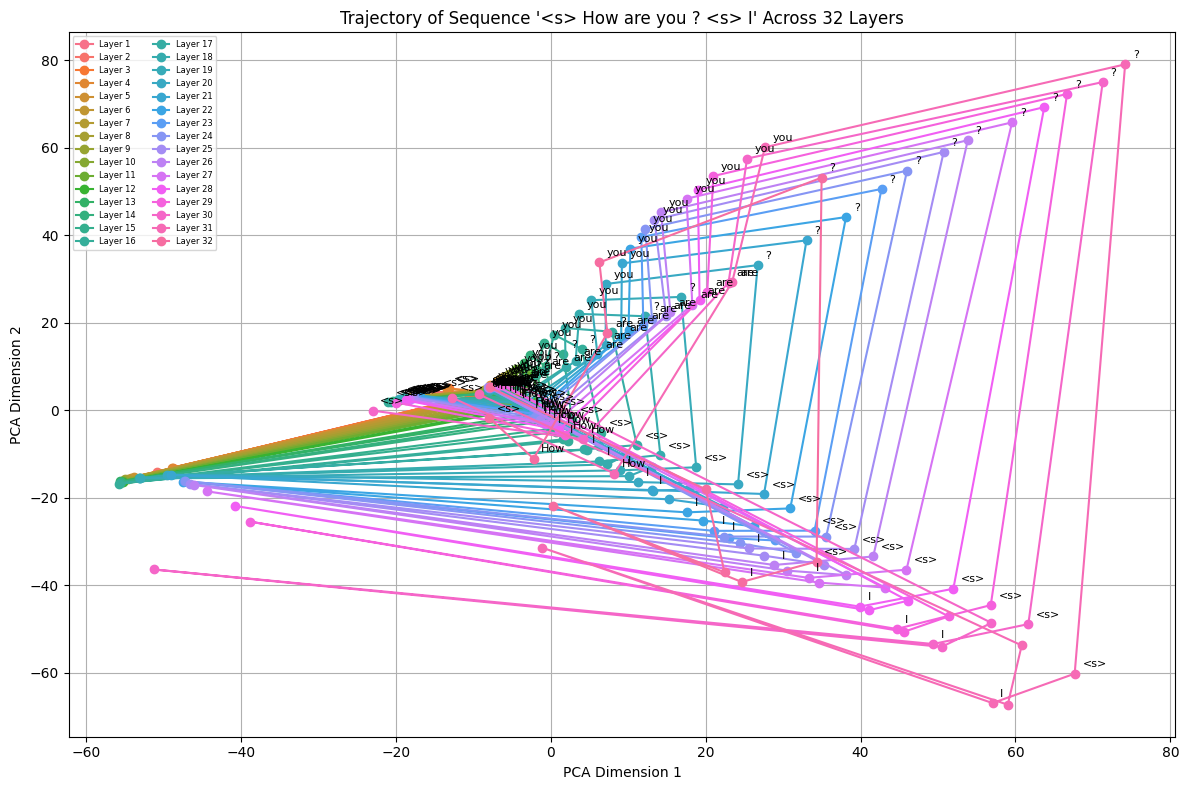

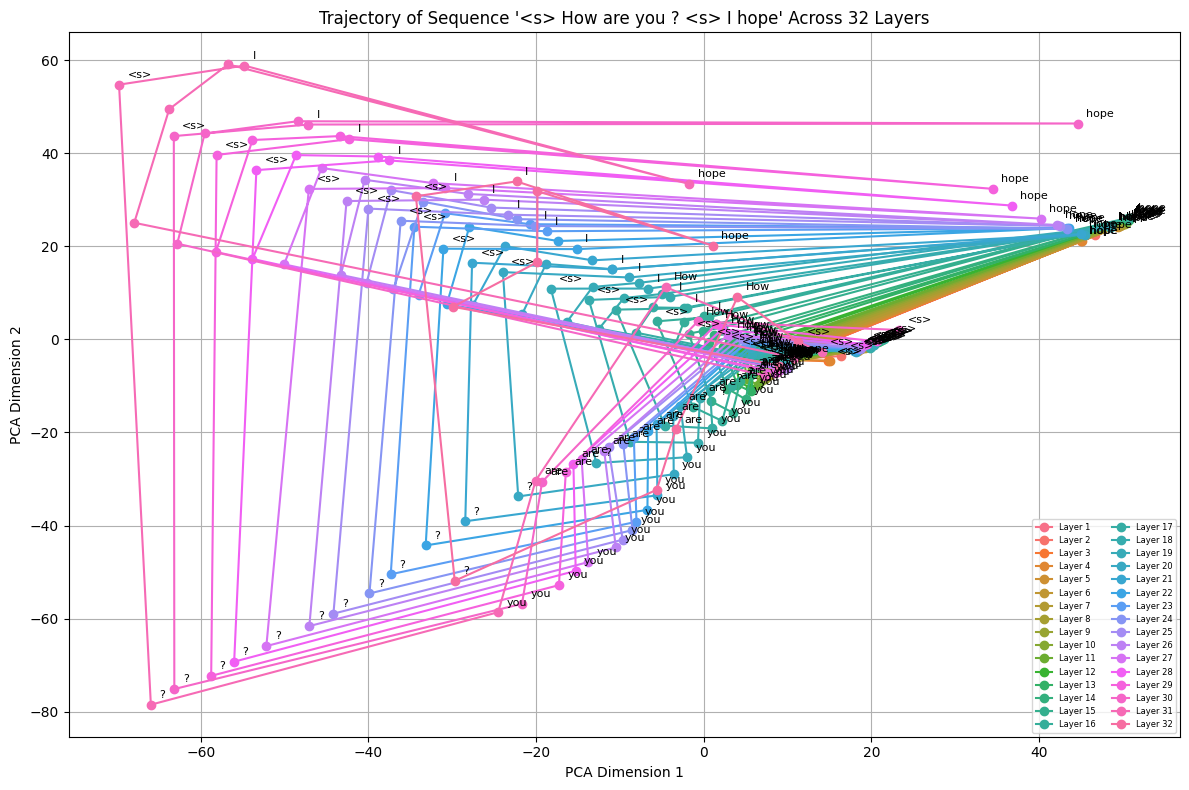

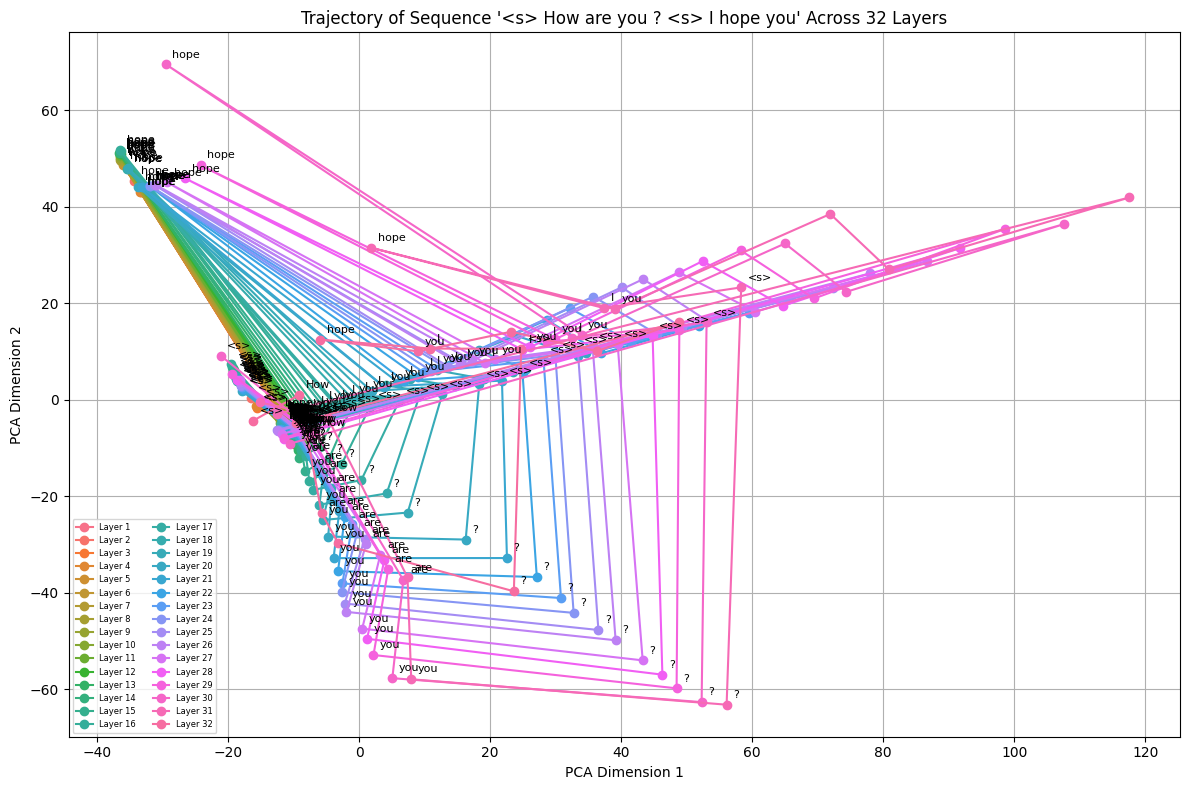

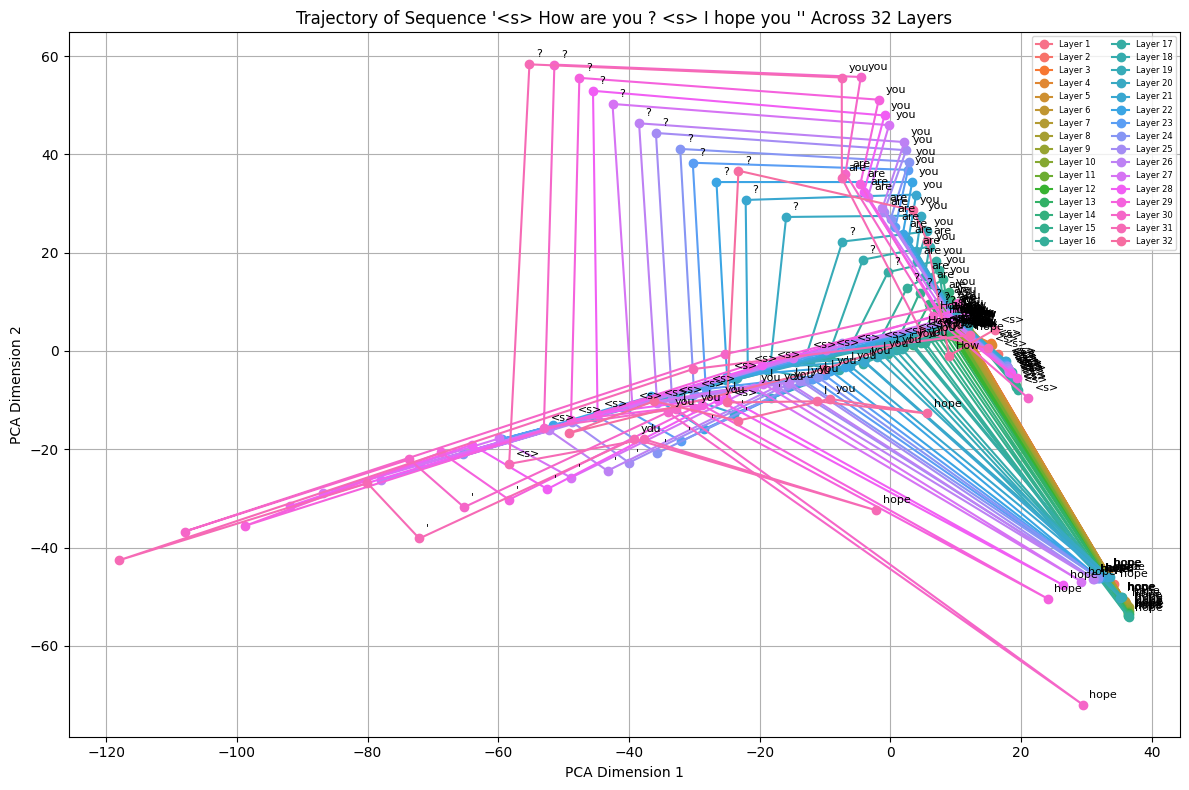

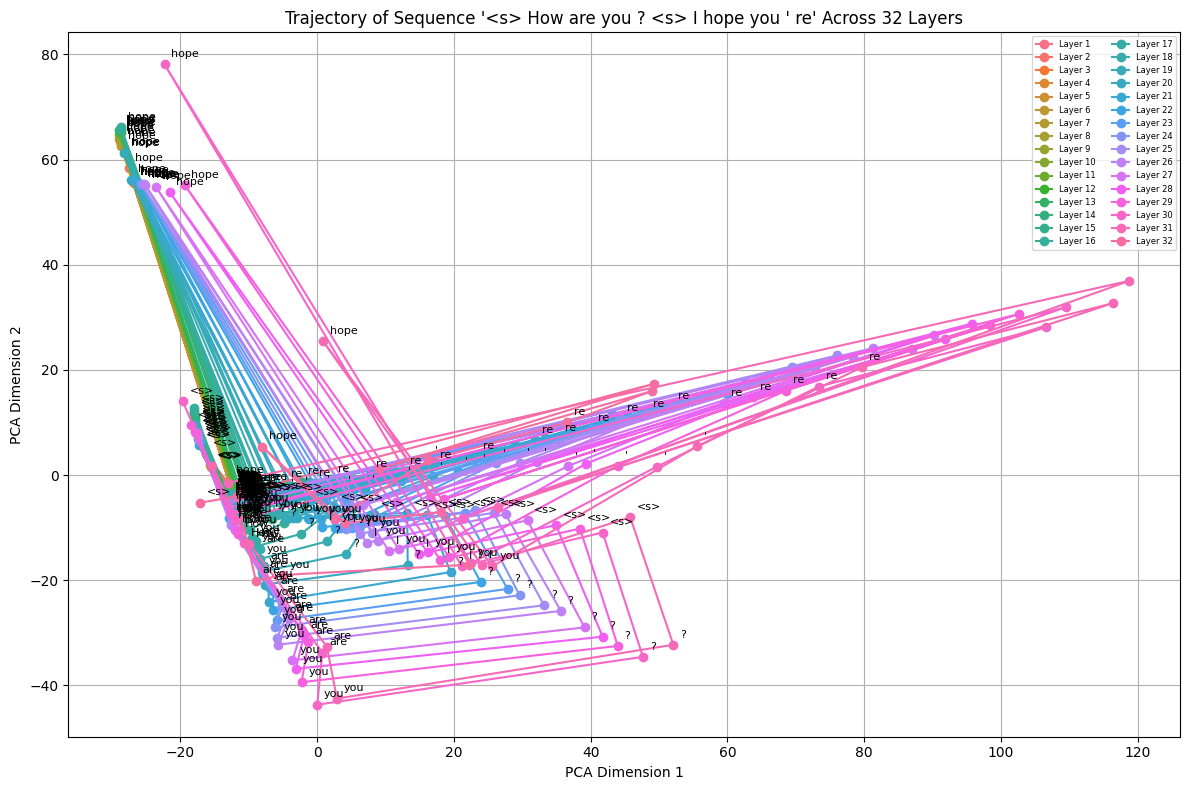

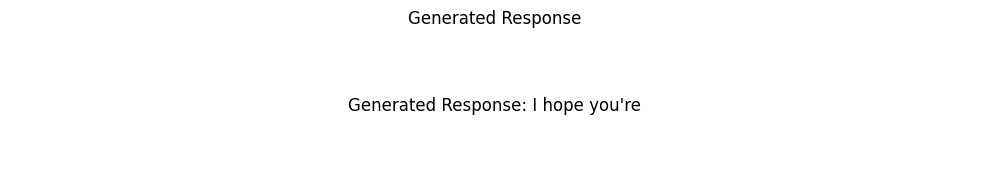

In [ ]:
# Part 2: Visualize Trajectories of Cumulative Sequences with Response
from transformers import AutoTokenizer, AutoModelForCausalLM, StoppingCriteria, StoppingCriteriaList
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Custom stopping criteria to limit response length
class MaxLengthCriteria(StoppingCriteria):
    def __init__(self, max_length):
        self.max_length = max_length
    def __call__(self, input_ids, scores, **kwargs):
        return input_ids.shape[1] >= self.max_length

# Step 1: Model and Tokenizer Setup
model_name = "meta-llama/Llama-2-7b-hf"
hf_token = ""  # Actual Hugging Face token

# Load tokenizer and model with token
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=hf_token,
    device_map="auto",
    offload_folder="offload",
    torch_dtype=torch.float16
)
model.eval()

# Step 2: Generate Response
input_text = "How are you?"
inputs = tokenizer(input_text, return_tensors="pt", add_special_tokens=True)
input_ids = inputs["input_ids"].to("cuda" if torch.cuda.is_available() else "cpu")
attention_mask = inputs["attention_mask"].to("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    stopping_criteria = StoppingCriteriaList([MaxLengthCriteria(max_length=10)])  # Limit to 10 tokens
    generated_ids = model.generate(
        input_ids,
        max_length=15,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=attention_mask,
        no_repeat_ngram_size=2,  # Prevent repetition of input
        stopping_criteria=stopping_criteria
    )
    full_output = tokenizer.decode(generated_ids[0], skip_special_tokens=False)
    input_len = input_ids.shape[1]
    response_ids = generated_ids[0][input_len:]  # Remove input tokens
    response = tokenizer.decode(response_ids, skip_special_tokens=True)
    print(f"Generated response: {response}")

# Step 3: Tokenize Input and Response
input_token_strs = [tokenizer.decode([token_id], skip_special_tokens=False).strip() for token_id in input_ids[0]]
input_token_strs = [t for t in input_token_strs if t]  # ['<s>', 'How', 'are', 'you', '?']
response_inputs = tokenizer(response, add_special_tokens=True, return_tensors="pt")
response_input_ids = response_inputs["input_ids"].to("cuda" if torch.cuda.is_available() else "cpu")
response_token_strs = [tokenizer.decode([token_id], skip_special_tokens=False).strip() for token_id in response_input_ids[0]]
response_token_strs = [t for t in response_token_strs if t]  # e.g., ['<s>', 'We', 'hope', 'you', '</s>']
print(f"Response tokens: {response_token_strs}")

# Step 4: Construct Cumulative Sequences
sequences = []
# Start with input tokens + first <s>
cumulative_seq = input_token_strs + ['<s>']
sequences.append(cumulative_seq)
# Add each response token progressively
for token in response_token_strs[1:]:  # Start from first response token after <s>
    cumulative_seq = cumulative_seq + [token]
    sequences.append(cumulative_seq.copy())
sequence_names = [' '.join(seq) for seq in sequences]  # Full sequence string for each

# Step 5: Process Each Sequence
all_reduced = []
for seq in sequences:
    # Tokenize the sequence
    seq_ids = tokenizer(" ".join(seq), return_tensors="pt", add_special_tokens=False)["input_ids"].to("cuda" if torch.cuda.is_available() else "cpu")
    if seq_ids[0][-1] != tokenizer.eos_token_id:
        seq_ids = torch.cat([seq_ids, torch.tensor([[tokenizer.eos_token_id]], device=seq_ids.device)], dim=1)
    # Get hidden states
    with torch.no_grad():
        outputs = model(seq_ids, output_hidden_states=True)
        hidden_states = outputs.hidden_states
    # Convert to numpy
    num_layers = len(hidden_states)
    num_tokens = seq_ids.shape[1]
    embed_dim = hidden_states[0].shape[-1]
    layer_matrix = np.stack([hs[0].cpu().numpy() for hs in hidden_states])
    # Preprocessing and PCA
    reshaped = layer_matrix.reshape(-1, embed_dim)
    scaler = StandardScaler()
    reshaped_normalized = scaler.fit_transform(reshaped)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(reshaped_normalized)
    reduced = reduced.reshape(num_layers, num_tokens, 2)
    all_reduced.append(reduced)

# Step 6: Visualization
transformer_layers = range(1, 33)  # 32 transformer layers
layer_colors = sns.color_palette("husl", 32)  # 32 colors

for i, (reduced, name, seq) in enumerate(zip(all_reduced, sequence_names, sequences)):
    plt.figure(figsize=(12, 8))
    for layer_idx in transformer_layers:
        coords = reduced[layer_idx]
        plt.plot(coords[:, 0], coords[:, 1], marker='o', color=layer_colors[layer_idx - 1], label=f"Layer {layer_idx}")
        for j, token in enumerate(seq):
                plt.text(coords[j, 0] + 1, coords[j, 1] + 1, token, fontsize=8, color='black', ha='left', va='bottom')
    plt.title(f"Trajectory of Sequence '{name}' Across 32 Layers")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.grid(True)
    plt.legend(fontsize=6, ncol=2)
    plt.tight_layout()
    plt.show()

# Graph 1: Display the response
plt.figure(figsize=(10, 2))
plt.text(0.5, 0.5, f"Generated Response: {response}", ha='center', va='center', fontsize=12)
plt.axis('off')
plt.title("Generated Response")
plt.tight_layout()
plt.show()

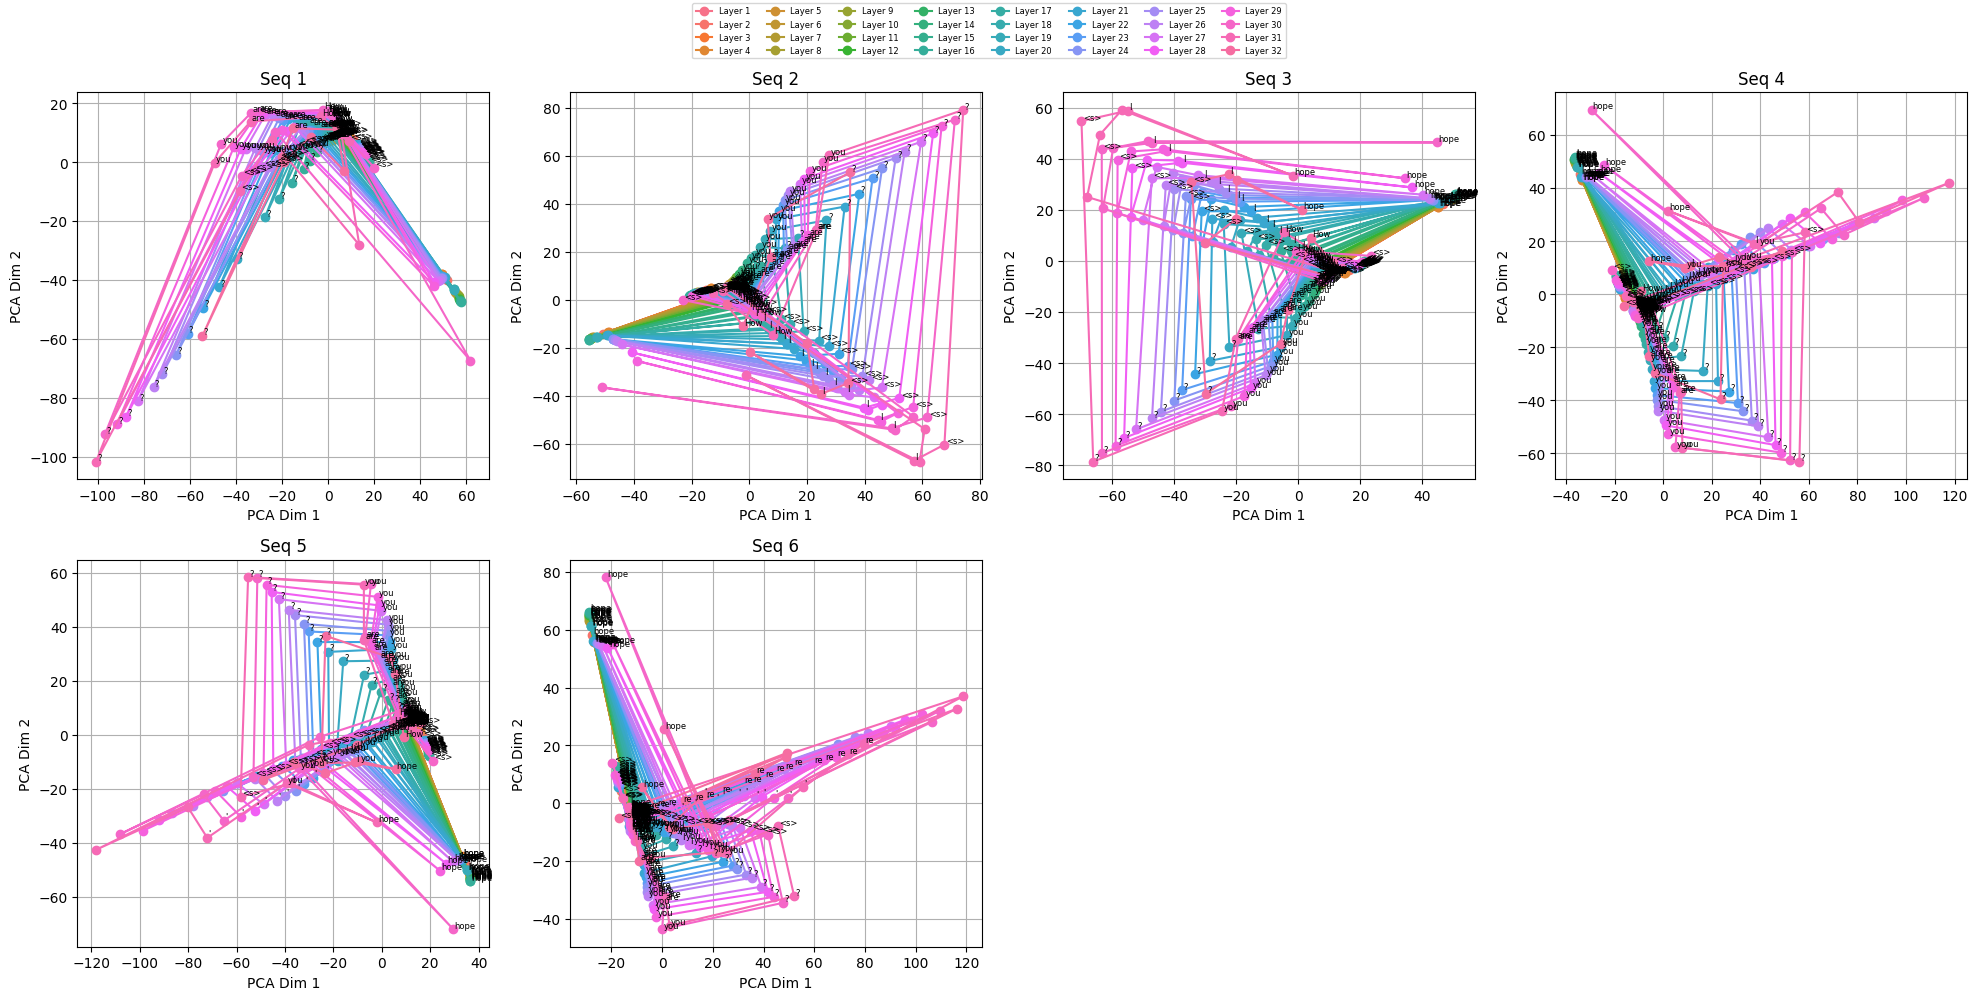

In [ ]:
import math

# Number of graphs = one per sequence
n_graphs = len(all_reduced)

# Layout: 4 per row
cols = 4
rows = math.ceil(n_graphs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
axes = axes.flatten()

for i, (reduced, name, seq) in enumerate(zip(all_reduced, sequence_names, sequences)):
    ax = axes[i]
    for layer_idx in transformer_layers:
        coords = reduced[layer_idx]
        ax.plot(coords[:, 0], coords[:, 1], marker='o',
                color=layer_colors[layer_idx - 1],
                label=f"Layer {layer_idx}")
        for j, token in enumerate(seq):
            ax.text(coords[j, 0] + 0.5, coords[j, 1] + 0.5, token,
                    fontsize=6, color='black')
    ax.set_title(f"Seq {i+1}")
    ax.set_xlabel("PCA Dim 1")
    ax.set_ylabel("PCA Dim 2")
    ax.grid(True)

# Hide any unused subplot slots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Place legend outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=6, ncol=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()
